Epoch 1/20
2917/2917 [==============================] - 11s 3ms/step - loss: 0.0129
Epoch 2/20
2917/2917 [==============================] - 11s 4ms/step - loss: 0.0104
Epoch 3/20
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0100
Epoch 4/20
2917/2917 [==============================] - 7s 3ms/step - loss: 0.0100
Epoch 5/20
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0099
Epoch 6/20
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0099
Epoch 7/20
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0099
Epoch 8/20
2917/2917 [==============================] - 15s 5ms/step - loss: 0.0098
Epoch 9/20
2917/2917 [==============================] - 9s 3ms/step - loss: 0.0098
Epoch 10/20
2917/2917 [==============================] - 9s 3ms/step - loss: 0.0098
Epoch 11/20
2917/2917 [==============================] - 9s 3ms/step - loss: 0.0098
Epoch 12/20
2917/2917 [==============================] - 7s 3ms/step - loss: 0.009

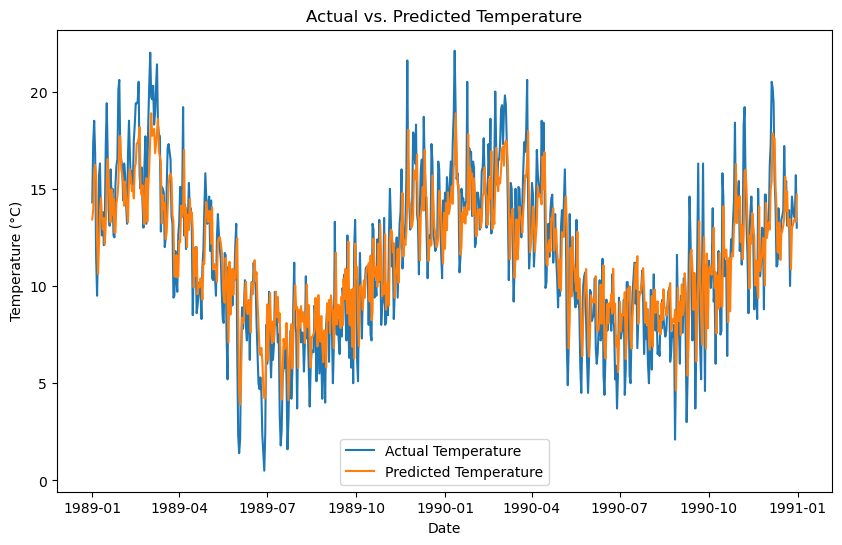

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv("Dataset.csv")

# Ensure that the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index for the time series
data.set_index('Date', inplace=True)

# Scale the 'Temp' data between 0 and 1
scaler = MinMaxScaler()
data['Temp_scaled'] = scaler.fit_transform(data[['Temp']])

# Define a function to create sequences for the LSTM model
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Define sequence length (number of previous time steps to consider for prediction)
sequence_length = 3  # Change this value as needed

# Create sequences
X, y = create_sequences(data['Temp_scaled'], sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input to fit the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential([
    LSTM(50, input_shape=(sequence_length, 1)),  # LSTM layer with 50 units
    Dense(1)  # Output layer with 1 neuron (regression task)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_orig, y_pred)
print("Mean Squared Error:", mse)

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test_orig, label='Actual Temperature')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Temperature')
plt.title("Actual vs. Predicted Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


23/23 [==============================] - 0s 3ms/step
Train MAE: 1.9837257856369672
Test MAE: 1.8357836863112773
Train MSE: 6.505172197951045
Test MSE: 5.406573415290192
Train RMSE: 2.550523906563325
Test RMSE: 2.325203951332053


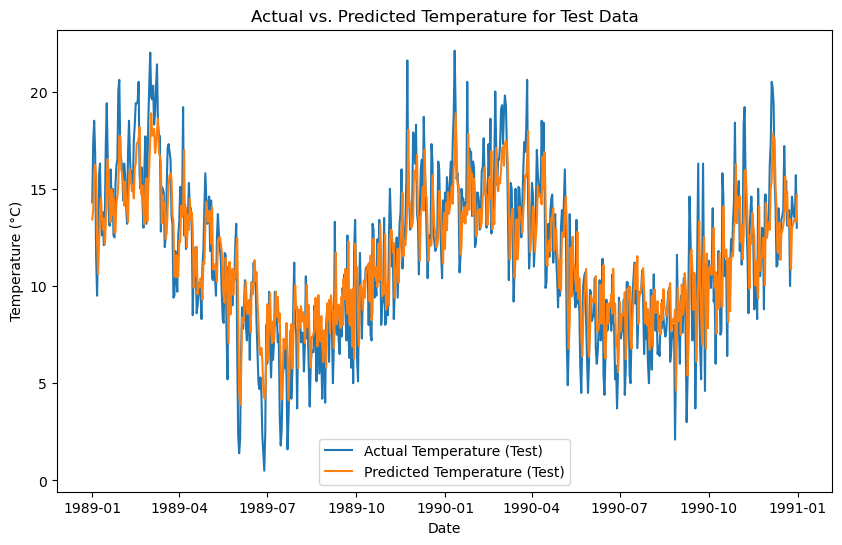

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert the data to original scale for both training and testing predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverse transform to get back to the original temperature scale
trainPredict_orig = scaler.inverse_transform(trainPredict)
testPredict_orig = scaler.inverse_transform(testPredict)

# The true (expected) values for training and testing data
trainY_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
testY_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
trainMAE = mean_absolute_error(trainY_orig, trainPredict_orig)
testMAE = mean_absolute_error(testY_orig, testPredict_orig)

print("Train MAE:", trainMAE)
print("Test MAE:", testMAE)

# Calculate Mean Squared Error (MSE)
trainMSE = mean_squared_error(trainY_orig, trainPredict_orig)
testMSE = mean_squared_error(testY_orig, testPredict_orig)

print("Train MSE:", trainMSE)
print("Test MSE:", testMSE)

# Calculate Root Mean Squared Error (RMSE)
trainRMSE = np.sqrt(trainMSE)
testRMSE = np.sqrt(testMSE)

print("Train RMSE:", trainRMSE)
print("Test RMSE:", testRMSE)

# Plotting the actual vs. predicted data for visual inspection
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(testY_orig):], testY_orig, label="Actual Temperature (Test)")
plt.plot(data.index[-len(testPredict_orig):], testPredict_orig, label="Predicted Temperature (Test)")
plt.title("Actual vs. Predicted Temperature for Test Data")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


## Save Weights

In [67]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [68]:
from keras.models import save_model
network_saved = save_model(model, 'weights.hdf5')

C:\Users\HP\AppData\Local\Temp\ipykernel_11372\2289195535.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(model, 'weights.hdf5')


In [69]:
with open('model.json', 'r') as json_file:
    json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_26", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 3, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "lstm_28_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "LSTM", "config": {"name": "lstm_28", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 3, 1], "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 50, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "recurrent_initializer": {"module": "keras.initializers", "class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "cl

In [71]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')

# network_loaded.compile(optimizer = 'Adam', loss='categorical_crossentropy',metrics=['accuracy'])

network_loaded.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [72]:
network_loaded.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 50)                10400     
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
